# Import libraries

In [1]:
# Re-install transformers
# !pip install -q transformers==4.55.4 faiss-cpu

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Sampler, DataLoader

import numpy as np
from safetensors.torch import load_model

In [3]:
from transformers import (
    BertTokenizer,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
    ErnieConfig,
    ErnieModel,
    EarlyStoppingCallback,
)

In [4]:
import gc
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, recall_score, precision_score

In [5]:
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

# Set seed for deterministic

In [6]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
# torch.use_deterministic_algorithms(True) 

# Constants

In [7]:
PATH_TO_DATASET = '/mnt/d/SemEval2026/subtask3'
MODEL_NAME = '/mnt/d/SemEval2026/ernie-3.0-xbase-zh'
BATCH_SIZE_TRAIN = 8
BATCH_SIZE_EVAL = 32

MODEL_HEAD_DROPOUT = 0.1

LANG = 'zho'
NUM_CLASSES = 6
K_FOLDS = 5

SAVE_DIR = f'/mnt/d/SemEval2026/Ernie3-Sub3-Ablation-No_Transfer-{LANG}'
TEMP_DIR = f'/mnt/d/SemEval2026/Ernie3-Sub3-temp-{LANG}'

In [8]:
SUBTASK1_FOLD_MODELS_DIR = f'/mnt/d/SemEval2026/Ernie3-Sub1-Final-{LANG}'
# SUBTASK1_TEST_PREDICTION = f'/mnt/d/SemEval2026/Ernie3-Sub1-Final-{LANG}/subtask_1/pred_{LANG}.csv'
SUBTASK1_TEST_PREDICTION = f'/mnt/d/SemEval2026/Ernie3-Sub1-Final-{LANG}/test/subtask_1/pred_{LANG}.csv'

In [9]:
SUBTASK2_COLUMNS = ['political', 'racial/ethnic', 'religious', 'gender/sexual', 'other']
SUBTASK3_COLUMNS = ['stereotype','vilification','dehumanization','extreme_language','lack_of_empathy','invalidation']

In [10]:
# Training configuration
LEARNING_RATE = 2e-5
MAX_STEPS = 3000
WEIGHT_DECAY = 0.01
LAYER_DECAY = 0.95
WARMUP_RATIO = 0.1
EARLY_STOPPING_PATIENCE = 5
EVAL_STEPS = LOGGING_STEPS = 100
FGM_EPSILON = 0.2

# Loss function

In [11]:
class AsymmetricLossOptimized(nn.Module):
    ''' Notice - optimized version, minimizes memory allocation and gpu uploading,
    favors inplace operations'''

    def __init__(self, gamma_neg=4, gamma_pos=1, clip=0.05, eps=1e-8, disable_torch_grad_focal_loss=False, reduction='sum'):
        super(AsymmetricLossOptimized, self).__init__()

        self.gamma_neg = gamma_neg
        self.gamma_pos = gamma_pos
        self.clip = clip
        self.disable_torch_grad_focal_loss = disable_torch_grad_focal_loss
        self.eps = eps

        # prevent memory allocation and gpu uploading every iteration, and encourages inplace operations
        self.targets = self.anti_targets = self.xs_pos = self.xs_neg = self.asymmetric_w = self.loss = None
        self.reduction = reduction

    def forward(self, x, y):
        """"
        Parameters
        ----------
        x: input logits
        y: targets (multi-label binarized vector)
        """

        self.targets = y
        self.anti_targets = 1 - y

        # Calculating Probabilities
        self.xs_pos = torch.sigmoid(x)
        self.xs_neg = 1.0 - self.xs_pos

        # Asymmetric Clipping
        if self.clip is not None and self.clip > 0:
            self.xs_neg.add_(self.clip).clamp_(max=1)

        # Basic CE calculation
        self.loss = self.targets * torch.log(self.xs_pos.clamp(min=self.eps))
        self.loss.add_(self.anti_targets * torch.log(self.xs_neg.clamp(min=self.eps)))

        # Asymmetric Focusing
        # if self.gamma_neg > 0 or self.gamma_pos > 0:
        if self.disable_torch_grad_focal_loss:
            torch.set_grad_enabled(False)
        self.xs_pos = self.xs_pos * self.targets
        self.xs_neg = self.xs_neg * self.anti_targets
        self.asymmetric_w = torch.pow(1 - self.xs_pos - self.xs_neg,
                                        self.gamma_pos * self.targets + self.gamma_neg * self.anti_targets)
        if self.disable_torch_grad_focal_loss:
            torch.set_grad_enabled(True)
        self.loss *= self.asymmetric_w

        if self.reduction == 'sum':
            return -self.loss.sum()
        elif self.reduction == 'mean':
            return -self.loss.mean()
        else:
            return -self.loss

# Prepare tokenizer and model

In [12]:
class FGM:
    def __init__(self, model):
        self.model = model
        self.backup = {}

    def attack(self, epsilon=1.0, emb_name='word_embeddings'):
        # Look for the embedding layer in the model
        for name, param in self.model.named_parameters():
            if param.requires_grad and emb_name in name:
                # Save the original embeddings
                self.backup[name] = param.data.clone()
                
                # Calculate the perturbation: noise = epsilon * gradient / norm(gradient)
                if param.grad is not None:
                    norm = torch.norm(param.grad)
                    if norm != 0 and not torch.isnan(norm):
                        r_at = epsilon * param.grad / norm
                        param.data.add_(r_at)

    def restore(self, emb_name='word_embeddings'):
        # Restore the original embeddings
        for name, param in self.model.named_parameters():
            if param.requires_grad and emb_name in name:
                assert name in self.backup
                param.data = self.backup[name]
        self.backup = {}

In [13]:
class ErnieSoftTripleModel_MultiLabel(nn.Module):
    def __init__(self, 
                 model_name='nghuyong/ernie-3.0-xbase-zh', 
                 num_classes=NUM_CLASSES, dropout=0.1, load_pretrained_encoder=True,
                 disable_asl=False,
                 asl_gamma_neg=4, asl_gamma_pos=1, asl_clip=0.05, asl_eps=1e-8,
                 asl_disable_torch_grad_focal_loss=False, asl_reduction='sum'
                 ):
        super().__init__()
        if load_pretrained_encoder:
            self.encoder = ErnieModel.from_pretrained(model_name)
        else:
            self.encoder = ErnieModel(ErnieConfig.from_pretrained(model_name))
        self.config = self.encoder.config
        self.hidden_size = self.config.hidden_size
        self.dropout = dropout
        
        self.classifier = nn.Sequential(
            nn.Linear(self.hidden_size, self.hidden_size),
            nn.LayerNorm(self.hidden_size),
            nn.GELU(),
            nn.Dropout(self.dropout),
            nn.Linear(self.hidden_size, num_classes)
        )

        if disable_asl:
            self.loss_fn = None
        else:
            self.loss_fn = AsymmetricLossOptimized(
                gamma_neg=asl_gamma_neg,
                gamma_pos=asl_gamma_pos,
                clip=asl_clip,
                eps=asl_eps,
                disable_torch_grad_focal_loss=asl_disable_torch_grad_focal_loss,
                reduction=asl_reduction
            )

    def forward(self, input_ids, attention_mask, labels=None, **kwargs):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)

        # 1. Extract [CLS] Token (Intent)
        cls_embedding = outputs.last_hidden_state[:, 0, :] # [Batch, Hidden]

        # Project to metric space (Stage 1)
        logits = self.classifier(cls_embedding)
        cls_embedding = F.normalize(cls_embedding, p=2, dim=1)

        loss = None
        if labels is not None and self.loss_fn is not None:
            loss = self.loss_fn(logits, labels)

        return {'loss': loss, 'logits': logits, 'embeddings': cls_embedding}

In [14]:
# Load the tokenizer
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

# Prepare dataset

In [15]:
class PolarizationDataset(torch.utils.data.Dataset):
  def __init__(self, data, tokenizer, max_length=96):
    """
    Args:
      data: Dict with 'texts', 'labels', and 'ids' keys
    """
    self.tokenizer = tokenizer
    self.max_length = max_length

    if isinstance(data, dict):
      self.texts = data['texts']
      self.labels = data['labels']
      # Add ID support. If not present, generate dummy IDs (0...N)
      self.ids = data.get('ids', list(range(len(self.texts))))
    else:
      raise ValueError("Data must be a single dict with 'texts', 'labels', and 'ids'")

    self.has_labels = any(label is not None for label in self.labels)

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, idx):
    text = self.texts[idx]
    label = self.labels[idx] if self.has_labels else None
    sample_id = self.ids[idx]

    encoding = self.tokenizer(
      text,
      truncation=True,
      padding='max_length', # Changed to max_length for consistent tensor shapes in batch
      max_length=self.max_length,
      return_tensors='pt'
    )

    item = {key: encoding[key].squeeze() for key in encoding.keys()}

    if label is not None:
      item['labels'] = torch.tensor(label, dtype=torch.float32)
    
    # Return ID so we can verify if needed, though Sampler handles the logic
    item['id'] = sample_id 

    return item

In [16]:
train_path = PATH_TO_DATASET + f'/train/{LANG}.csv'
df = pd.read_csv(train_path)
df = df[df[SUBTASK3_COLUMNS].sum(axis=1) > 0]

In [17]:
mskf = MultilabelStratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=SEED)

In [18]:
fold_idx = []
for train_idx, val_idx in mskf.split(df, df[SUBTASK3_COLUMNS].values):
    fold_idx.append((train_idx, val_idx))

# Training process

## Collator

In [19]:
data_collator = DataCollatorWithPadding(tokenizer)

## Trainers

In [20]:
class FGMTrainer(Trainer):
    def __init__(self, *args, fgm_epsilon=0.0, **kwargs):
        """
        Args:
            fgm_epsilon: Epsilon value for FGM attack
            *args, **kwargs: Standard Trainer arguments
        """
        super().__init__(*args, **kwargs)

        self.fgm = FGM(self.model)
        self.fgm_epsilon = fgm_epsilon

    def training_step(self, model, inputs, num_items_in_batch=None):
        model.train()
        inputs = self._prepare_inputs(inputs)
        
        # Ensure FGM uses the correct model (in case of wrapping)
        self.fgm.model = model

        # 1. Standard Forward & Backward
        # This call populates param.grad for all trainable params used in the loss
        with self.compute_loss_context_manager():
            loss = self.compute_loss(model, inputs)
            
        if self.args.n_gpu > 1:
            loss = loss.mean() 

        # Standard backward pass
        self.accelerator.backward(loss)

        if self.fgm_epsilon <= 0.0:
            # No FGM attack, return standard loss
            return loss.detach()

        # 2. FGM Attack
        # NOW gradients should be populated. 
        # The check inside attack() handles any unused params.
        self.fgm.attack(epsilon=self.fgm_epsilon, emb_name='word_embeddings')
        
        # 3. Adversarial Forward & Backward
        with self.compute_loss_context_manager():
            loss_adv = self.compute_loss(model, inputs)
            
        if self.args.n_gpu > 1:
            loss_adv = loss_adv.mean()

        # Accumulate adversarial gradients
        self.accelerator.backward(loss_adv)
        
        # 4. Restore original embeddings
        self.fgm.restore()
        
        # Return standard loss for logging
        return loss.detach()

## Callbacks

In [21]:
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=EARLY_STOPPING_PATIENCE
)

## Compute metrics

In [22]:
def compute_metrics(p):
    probs = torch.sigmoid(torch.tensor(p.predictions[0])).numpy()
    labels = p.label_ids.astype(int)
    
    threshold_range = np.linspace(0.1, 0.9, num=81)
    
    # Find optimal threshold for each class independently
    best_thresholds = []
    
    for class_idx in range(NUM_CLASSES):
        best_f1_class = 0.0
        best_thresh_class = 0.5
        
        for thresh in threshold_range:
            # Apply threshold only to this class
            preds_class = (probs[:, class_idx] > thresh).astype(int)
            labels_class = labels[:, class_idx]
            
            # Calculate F1 for this class
            f1_class = f1_score(labels_class, preds_class, average='binary', zero_division=0)
            
            if f1_class > best_f1_class:
                best_f1_class = f1_class
                best_thresh_class = thresh
        
        best_thresholds.append(best_thresh_class)
    
    # Apply class-specific thresholds to get final predictions
    preds = np.zeros_like(probs, dtype=int)
    for class_idx in range(NUM_CLASSES):
        preds[:, class_idx] = (probs[:, class_idx] > best_thresholds[class_idx]).astype(int)
    
    # Multi-label metrics (samples average treats each sample equally)
    metrics = {
        'f1_macro': f1_score(labels, preds, average='macro', zero_division=0),
        'precision_macro': precision_score(labels, preds, average='macro', zero_division=0),
        'recall_macro': recall_score(labels, preds, average='macro', zero_division=0),
        'accuracy_exact': float((preds == labels).all(axis=1).mean()),
    }
    
    # Add per-label F1 scores and thresholds for detailed monitoring
    per_label_f1 = f1_score(labels, preds, average=None, zero_division=0)
    for i, (name, f1_val, thresh) in enumerate(zip(SUBTASK3_COLUMNS, per_label_f1, best_thresholds)):
        metrics[f'f1_{name.replace("/", "_")}'] = float(f1_val)
        metrics[f'threshold_{name.replace("/", "_")}'] = float(thresh)
    
    return metrics

## Training loop

In [23]:
def get_optimizer_grouped_parameters(model, learning_rate, weight_decay, layer_decay=0.95):
    """
    Creates parameter groups for LLRD (Layer-wise Learning Rate Decay).
    
    Structure:
    - Classifier/Projection Head: lr = learning_rate (High)
    - Encoder Layer 12: lr = learning_rate
    - Encoder Layer 11: lr = learning_rate * layer_decay
    - ...
    - Embeddings: lr = learning_rate * (layer_decay^13)
    """
    
    # 1. Define sets of parameter names for grouping
    no_decay = ["bias", "LayerNorm.weight"]
    
    # 2. Separate Backbone from Heads
    # We identify the backbone by the attribute name 'encoder' in your ErnieTripletModel
    backbone_prefix = "encoder" 
    
    optimizer_grouped_parameters = []
    
    # --- GROUP A: The Heads (Classifier & Projection) ---
    # These need the highest LR because they are trained from scratch
    head_params = []
    head_params_no_decay = []
    
    for name, param in model.named_parameters():
        if not param.requires_grad:
            continue
            
        # If it's NOT part of the encoder, it's part of the head (classifier or projection)
        if not name.startswith(backbone_prefix):
            if any(nd in name for nd in no_decay):
                head_params_no_decay.append(param)
            else:
                head_params.append(param)

    optimizer_grouped_parameters.extend([
        {
            "params": head_params,
            "weight_decay": weight_decay,
            "lr": learning_rate,  # Max LR
        },
        {
            "params": head_params_no_decay,
            "weight_decay": 0.0,
            "lr": learning_rate,  # Max LR
        },
    ])

    # --- GROUP B: The Backbone (Layer-wise Decay) ---
    # ERNIE/BERT typically has embeddings + 12 encoder layers + pooler
    
    # We iterate carefully to assign LRs.
    # Logic: Layer 12 is 'closest' to the head, so it gets higher LR.
    
    # Initialize current LR
    current_lr = learning_rate
    
    # Get all backbone parameters
    # We group them by layer index to assign LRs
    # ERNIE structure usually: encoder.encoder.layer.0. ...
    
    # 1. The Encoder Layers (Top to Bottom: 11 -> 0)
    # Assuming standard 12-layer model. Adjust range if xbase differs (xbase is usually 12).
    num_layers = model.config.num_hidden_layers
    
    for layer_index in range(num_layers - 1, -1, -1):
        layer_params = []
        layer_params_no_decay = []
        
        prefix = f"{backbone_prefix}.encoder.layer.{layer_index}."
        
        for name, param in model.named_parameters():
            if not param.requires_grad:
                continue
            
            if name.startswith(prefix):
                if any(nd in name for nd in no_decay):
                    layer_params_no_decay.append(param)
                else:
                    layer_params.append(param)
        
        # Add this layer's params
        if layer_params or layer_params_no_decay:
            optimizer_grouped_parameters.extend([
                {"params": layer_params, "weight_decay": weight_decay, "lr": current_lr},
                {"params": layer_params_no_decay, "weight_decay": 0.0, "lr": current_lr},
            ])
        
        # Decay LR for the NEXT layer down
        current_lr *= layer_decay

    # 2. Embeddings (The Foundation - Gets the smallest LR)
    embed_params = []
    embed_params_no_decay = []
    embed_prefix = f"{backbone_prefix}.embeddings."
    
    for name, param in model.named_parameters():
        if not param.requires_grad:
            continue
        
        if name.startswith(embed_prefix):
            if any(nd in name for nd in no_decay):
                embed_params_no_decay.append(param)
            else:
                embed_params.append(param)

    optimizer_grouped_parameters.extend([
        {"params": embed_params, "weight_decay": weight_decay, "lr": current_lr},
        {"params": embed_params_no_decay, "weight_decay": 0.0, "lr": current_lr},
    ])

    return optimizer_grouped_parameters

In [24]:
# for i, (train_index, val_index) in enumerate(skfold.split(df['text'], df['polarization'])):
for i, (train_index, val_index) in enumerate(fold_idx):
    print(f"Starting fold {i+1}")

    # Prepare fold-specific datasets
    fold_train_data = {
        'texts': [df['text'][j] for j in train_index],
        'labels': [df[SUBTASK3_COLUMNS].iloc[j].to_list() for j in train_index]
    }
    fold_val_data = {
        'texts': [df['text'][j] for j in val_index],
        'labels': [df[SUBTASK3_COLUMNS].iloc[j].to_list() for j in val_index]
    }

    fold_train_dataset = PolarizationDataset(fold_train_data, tokenizer)
    fold_val_dataset = PolarizationDataset(fold_val_data, tokenizer)

    # Initialize model
    model = ErnieSoftTripleModel_MultiLabel(
        model_name=MODEL_NAME, num_classes=NUM_CLASSES, dropout=MODEL_HEAD_DROPOUT,
        asl_gamma_neg=torch.tensor([4.0, 4.0, 3.5, 3.5, 2.0, 2.0]).to('cuda'),
        asl_gamma_pos=torch.tensor([1.0, 1.0, 1.0, 1.0, 1.0, 1.0]).to('cuda')
    )   
    # load_model(model, SUBTASK1_FOLD_MODELS_DIR + f"/fold_2_best_model/model.safetensors", strict=False) # use best fold 2 model from subtask 1

    optimizer_grouped_parameters = get_optimizer_grouped_parameters(
        model=model,
        learning_rate=LEARNING_RATE,
        weight_decay=WEIGHT_DECAY,
        layer_decay=LAYER_DECAY,
    )

    ### Training ###
    training_args = TrainingArguments(
        output_dir=TEMP_DIR + f'/fold_{i+1}',
        max_steps=MAX_STEPS,
        lr_scheduler_type="cosine",
        per_device_train_batch_size=BATCH_SIZE_TRAIN,
        per_device_eval_batch_size=BATCH_SIZE_EVAL,
        eval_strategy="steps",
        eval_steps=EVAL_STEPS,
        save_strategy="best",
        logging_steps=LOGGING_STEPS,
        disable_tqdm=False,
        report_to="none",
        metric_for_best_model="f1_macro",
        load_best_model_at_end=True,
        save_total_limit=2,
        dataloader_num_workers=4,
        warmup_ratio=WARMUP_RATIO,
        bf16=True,
    )

    trainer = FGMTrainer(
        model=model,
        args=training_args,
        train_dataset=fold_train_dataset,
        eval_dataset=fold_val_dataset,
        data_collator=data_collator,
        fgm_epsilon=FGM_EPSILON,
        optimizers=(torch.optim.AdamW(optimizer_grouped_parameters), None),
        callbacks=[early_stopping_callback],
        compute_metrics=compute_metrics
    )

    trainer.train()

    ### Save the best model for this fold ###
    os.makedirs(f"{SAVE_DIR}", exist_ok=True)
    trainer.save_model(f"{SAVE_DIR}/fold_{i+1}_best_model")


    ### Clean up for next fold ###
    del fold_train_dataset
    del fold_val_dataset
    del trainer
    del model

    gc.collect()
    torch.cuda.empty_cache()

Starting fold 1


Step,Training Loss,Validation Loss,F1 Macro,Precision Macro,Recall Macro,Accuracy Exact,F1 Stereotype,Threshold Stereotype,F1 Vilification,Threshold Vilification,F1 Dehumanization,Threshold Dehumanization,F1 Extreme Language,Threshold Extreme Language,F1 Lack Of Empathy,Threshold Lack Of Empathy,F1 Invalidation,Threshold Invalidation
100,6.208100,19.964424,0.382727,0.272696,0.725497,0.007042,0.754772,0.580000,0.545126,0.570000,0.206897,0.470000,0.301435,0.480000,0.289720,0.430000,0.198413,0.330000
200,5.257100,17.915924,0.510475,0.414584,0.698784,0.215962,0.799325,0.670000,0.690027,0.640000,0.396825,0.470000,0.359375,0.490000,0.433735,0.430000,0.383562,0.370000
300,4.659300,15.652010,0.603090,0.531151,0.707810,0.380282,0.850000,0.630000,0.743363,0.620000,0.469565,0.440000,0.510067,0.490000,0.517241,0.340000,0.528302,0.360000
400,4.173500,14.275455,0.640675,0.617819,0.677464,0.453052,0.864662,0.610000,0.758824,0.560000,0.567901,0.510000,0.474074,0.610000,0.544444,0.420000,0.634146,0.500000
500,3.500500,14.080562,0.654738,0.673856,0.639764,0.507042,0.873346,0.570000,0.763514,0.700000,0.592593,0.590000,0.512000,0.570000,0.544118,0.550000,0.642857,0.610000
600,3.141700,14.695476,0.662465,0.618112,0.718880,0.455399,0.874317,0.680000,0.781870,0.620000,0.581395,0.590000,0.541667,0.570000,0.544379,0.320000,0.651163,0.400000
700,2.402600,15.565817,0.694422,0.679581,0.718037,0.500000,0.860558,0.780000,0.772152,0.600000,0.674157,0.560000,0.571429,0.510000,0.588235,0.500000,0.700000,0.320000
800,2.112900,15.233808,0.691204,0.698753,0.696569,0.518779,0.877589,0.670000,0.777465,0.660000,0.674419,0.610000,0.564516,0.620000,0.577181,0.530000,0.676056,0.420000
900,1.758900,16.622276,0.691060,0.642126,0.762825,0.490610,0.859345,0.650000,0.794286,0.510000,0.666667,0.500000,0.569231,0.570000,0.590164,0.460000,0.666667,0.510000
1000,1.327600,18.660395,0.694930,0.663742,0.738034,0.495305,0.863813,0.670000,0.772222,0.590000,0.696629,0.660000,0.604651,0.610000,0.573171,0.620000,0.659091,0.490000


Saving vocabulary to /mnt/d/SemEval2026/Ernie3-Sub3-temp-zho/fold_1/checkpoint-100/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to /mnt/d/SemEval2026/Ernie3-Sub3-temp-zho/fold_1/checkpoint-200/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to /mnt/d/SemEval2026/Ernie3-Sub3-temp-zho/fold_1/checkpoint-300/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to /mnt/d/SemEval2026/Ernie3-Sub3-temp-zho/fold_1/checkpoint-400/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to /mnt/d/SemEval2026/Ernie3-Sub3-temp-zho/fold_1/checkpoint-500/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to /mnt/d/SemEval2026/Ernie3-Sub3-temp-zho/fold_1/checkpo

Starting fold 2


Step,Training Loss,Validation Loss,F1 Macro,Precision Macro,Recall Macro,Accuracy Exact,F1 Stereotype,Threshold Stereotype,F1 Vilification,Threshold Vilification,F1 Dehumanization,Threshold Dehumanization,F1 Extreme Language,Threshold Extreme Language,F1 Lack Of Empathy,Threshold Lack Of Empathy,F1 Invalidation,Threshold Invalidation
100,6.591300,21.308989,0.390000,0.271338,0.880598,0.002410,0.767857,0.610000,0.568841,0.530000,0.190265,0.320000,0.314136,0.460000,0.283333,0.250000,0.215569,0.350000
200,5.140500,18.890497,0.476279,0.389071,0.665343,0.187952,0.809061,0.650000,0.682796,0.550000,0.237705,0.450000,0.427807,0.470000,0.366972,0.470000,0.333333,0.400000
300,4.384700,17.888529,0.588768,0.573636,0.606594,0.383133,0.850277,0.470000,0.731563,0.640000,0.370370,0.460000,0.521739,0.500000,0.517483,0.470000,0.541176,0.450000
400,4.197400,15.156572,0.635105,0.579140,0.715785,0.414458,0.855072,0.650000,0.744048,0.580000,0.568627,0.460000,0.555556,0.490000,0.494737,0.440000,0.592593,0.440000
500,3.534300,15.397854,0.655737,0.618250,0.727676,0.404819,0.864762,0.670000,0.747826,0.560000,0.587156,0.590000,0.575342,0.480000,0.548223,0.470000,0.611111,0.490000
600,3.178700,13.696614,0.680988,0.690781,0.684111,0.491566,0.873518,0.700000,0.773006,0.650000,0.580000,0.530000,0.598291,0.580000,0.611111,0.490000,0.650000,0.460000
700,2.905100,15.800818,0.686590,0.714804,0.664320,0.510843,0.874759,0.610000,0.764331,0.580000,0.674419,0.520000,0.573529,0.470000,0.584615,0.640000,0.647887,0.470000
800,2.202200,14.830766,0.710088,0.695389,0.728640,0.491566,0.868069,0.700000,0.773256,0.610000,0.720930,0.590000,0.618705,0.540000,0.596026,0.540000,0.683544,0.440000
900,1.685100,17.486898,0.697016,0.703860,0.703690,0.489157,0.864971,0.710000,0.765625,0.450000,0.692308,0.690000,0.625954,0.550000,0.575342,0.580000,0.657895,0.390000
1000,1.355200,18.492029,0.716610,0.720899,0.714679,0.527711,0.861940,0.520000,0.787879,0.470000,0.758621,0.560000,0.641221,0.750000,0.600000,0.530000,0.650000,0.650000


Saving vocabulary to /mnt/d/SemEval2026/Ernie3-Sub3-temp-zho/fold_2/checkpoint-100/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to /mnt/d/SemEval2026/Ernie3-Sub3-temp-zho/fold_2/checkpoint-200/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to /mnt/d/SemEval2026/Ernie3-Sub3-temp-zho/fold_2/checkpoint-300/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to /mnt/d/SemEval2026/Ernie3-Sub3-temp-zho/fold_2/checkpoint-400/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to /mnt/d/SemEval2026/Ernie3-Sub3-temp-zho/fold_2/checkpoint-500/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to /mnt/d/SemEval2026/Ernie3-Sub3-temp-zho/fold_2/checkpo

Starting fold 3


Step,Training Loss,Validation Loss,F1 Macro,Precision Macro,Recall Macro,Accuracy Exact,F1 Stereotype,Threshold Stereotype,F1 Vilification,Threshold Vilification,F1 Dehumanization,Threshold Dehumanization,F1 Extreme Language,Threshold Extreme Language,F1 Lack Of Empathy,Threshold Lack Of Empathy,F1 Invalidation,Threshold Invalidation
100,6.327100,20.223497,0.384325,0.278814,0.682374,0.021077,0.752562,0.550000,0.576842,0.570000,0.193548,0.380000,0.285714,0.490000,0.283262,0.430000,0.214022,0.260000
200,5.117700,18.792683,0.498959,0.421035,0.646703,0.220141,0.783193,0.580000,0.681055,0.660000,0.287425,0.460000,0.427807,0.580000,0.378378,0.470000,0.435897,0.370000
300,4.627800,17.476303,0.555126,0.470625,0.690484,0.330211,0.810544,0.680000,0.745407,0.460000,0.363636,0.400000,0.516854,0.540000,0.462500,0.510000,0.431818,0.480000
400,4.156000,15.034204,0.603916,0.561422,0.661234,0.379391,0.821643,0.730000,0.743662,0.570000,0.471698,0.430000,0.458599,0.510000,0.516129,0.390000,0.611765,0.470000
500,3.383200,15.583323,0.649623,0.642095,0.671290,0.423888,0.845124,0.500000,0.761905,0.660000,0.575000,0.570000,0.522727,0.460000,0.526316,0.580000,0.666667,0.660000
600,3.194500,14.437752,0.651039,0.614408,0.704190,0.442623,0.837945,0.750000,0.774194,0.590000,0.529915,0.360000,0.571429,0.570000,0.556391,0.450000,0.636364,0.320000
700,2.379100,13.974159,0.671344,0.660942,0.710556,0.466042,0.850000,0.550000,0.772861,0.570000,0.566038,0.440000,0.560000,0.610000,0.612500,0.470000,0.666667,0.640000
800,2.102500,14.841296,0.691919,0.660423,0.746503,0.463700,0.855019,0.680000,0.783172,0.660000,0.611111,0.520000,0.617284,0.500000,0.600000,0.330000,0.684932,0.500000
900,1.782100,16.697701,0.672920,0.645851,0.716294,0.463700,0.848369,0.770000,0.783439,0.660000,0.595745,0.480000,0.580645,0.640000,0.571429,0.400000,0.657895,0.430000
1000,1.204900,19.135235,0.666670,0.635265,0.711263,0.477752,0.853480,0.650000,0.770186,0.540000,0.612613,0.380000,0.573529,0.590000,0.553846,0.340000,0.636364,0.370000


Saving vocabulary to /mnt/d/SemEval2026/Ernie3-Sub3-temp-zho/fold_3/checkpoint-100/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to /mnt/d/SemEval2026/Ernie3-Sub3-temp-zho/fold_3/checkpoint-200/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to /mnt/d/SemEval2026/Ernie3-Sub3-temp-zho/fold_3/checkpoint-300/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to /mnt/d/SemEval2026/Ernie3-Sub3-temp-zho/fold_3/checkpoint-400/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to /mnt/d/SemEval2026/Ernie3-Sub3-temp-zho/fold_3/checkpoint-500/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to /mnt/d/SemEval2026/Ernie3-Sub3-temp-zho/fold_3/checkpo

Starting fold 4


Step,Training Loss,Validation Loss,F1 Macro,Precision Macro,Recall Macro,Accuracy Exact,F1 Stereotype,Threshold Stereotype,F1 Vilification,Threshold Vilification,F1 Dehumanization,Threshold Dehumanization,F1 Extreme Language,Threshold Extreme Language,F1 Lack Of Empathy,Threshold Lack Of Empathy,F1 Invalidation,Threshold Invalidation
100,6.242700,20.292507,0.388462,0.275996,0.819364,0.002375,0.761062,0.530000,0.553971,0.560000,0.185745,0.320000,0.299169,0.480000,0.318367,0.400000,0.212454,0.270000
200,5.164900,19.170084,0.486066,0.401716,0.662999,0.187648,0.790323,0.660000,0.673854,0.480000,0.241667,0.440000,0.416185,0.510000,0.420382,0.350000,0.373984,0.310000
300,4.540300,17.033642,0.584007,0.522433,0.686764,0.356295,0.850095,0.520000,0.730878,0.650000,0.435644,0.520000,0.450000,0.520000,0.526316,0.440000,0.511111,0.390000
400,4.051000,14.741189,0.619162,0.604313,0.651777,0.437055,0.866667,0.590000,0.749311,0.570000,0.485714,0.520000,0.503226,0.450000,0.529412,0.470000,0.580645,0.480000
500,3.455200,15.049183,0.638569,0.571591,0.726940,0.420428,0.870674,0.510000,0.754821,0.600000,0.568421,0.450000,0.491018,0.570000,0.559524,0.340000,0.586957,0.490000
600,3.103600,14.126652,0.648638,0.626664,0.688050,0.470309,0.873294,0.620000,0.765060,0.590000,0.560976,0.580000,0.560606,0.590000,0.573333,0.470000,0.558559,0.370000
700,2.533900,15.253132,0.671465,0.649640,0.717978,0.453682,0.881481,0.600000,0.761329,0.540000,0.613636,0.620000,0.542169,0.540000,0.573034,0.390000,0.657143,0.580000
800,2.228600,16.331419,0.679244,0.664904,0.723501,0.467933,0.863469,0.550000,0.764045,0.530000,0.608696,0.490000,0.571429,0.700000,0.611111,0.500000,0.656716,0.700000
900,1.665000,17.877335,0.672054,0.697746,0.663047,0.508314,0.882353,0.710000,0.793750,0.630000,0.595238,0.760000,0.553191,0.640000,0.571429,0.330000,0.636364,0.620000
1000,1.360100,18.721737,0.683025,0.626689,0.755631,0.467933,0.870722,0.640000,0.773639,0.570000,0.627451,0.590000,0.558442,0.490000,0.601227,0.440000,0.666667,0.380000


Saving vocabulary to /mnt/d/SemEval2026/Ernie3-Sub3-temp-zho/fold_4/checkpoint-100/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to /mnt/d/SemEval2026/Ernie3-Sub3-temp-zho/fold_4/checkpoint-200/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to /mnt/d/SemEval2026/Ernie3-Sub3-temp-zho/fold_4/checkpoint-300/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to /mnt/d/SemEval2026/Ernie3-Sub3-temp-zho/fold_4/checkpoint-400/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to /mnt/d/SemEval2026/Ernie3-Sub3-temp-zho/fold_4/checkpoint-500/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to /mnt/d/SemEval2026/Ernie3-Sub3-temp-zho/fold_4/checkpo

Starting fold 5


Step,Training Loss,Validation Loss,F1 Macro,Precision Macro,Recall Macro,Accuracy Exact,F1 Stereotype,Threshold Stereotype,F1 Vilification,Threshold Vilification,F1 Dehumanization,Threshold Dehumanization,F1 Extreme Language,Threshold Extreme Language,F1 Lack Of Empathy,Threshold Lack Of Empathy,F1 Invalidation,Threshold Invalidation
100,6.002900,19.544163,0.392940,0.284794,0.799761,0.013889,0.751118,0.610000,0.560364,0.630000,0.218069,0.420000,0.316547,0.470000,0.321285,0.410000,0.190255,0.280000
200,4.997900,18.575857,0.499886,0.431539,0.676015,0.180556,0.785211,0.690000,0.728972,0.600000,0.330097,0.400000,0.428571,0.530000,0.398340,0.260000,0.328125,0.330000
300,4.557200,16.369331,0.558900,0.508578,0.667069,0.300926,0.806283,0.610000,0.750853,0.660000,0.367089,0.500000,0.452632,0.620000,0.433333,0.490000,0.543210,0.500000
400,4.016400,15.308086,0.626043,0.579064,0.692885,0.400463,0.828467,0.440000,0.782334,0.610000,0.491228,0.460000,0.522727,0.530000,0.503597,0.520000,0.627907,0.400000
500,3.654300,14.586495,0.647236,0.639792,0.667744,0.428241,0.845124,0.700000,0.782313,0.670000,0.511628,0.520000,0.540541,0.560000,0.537143,0.380000,0.666667,0.380000
600,2.987900,13.292916,0.665435,0.636062,0.716420,0.442130,0.840304,0.570000,0.795252,0.610000,0.613636,0.530000,0.580153,0.600000,0.520408,0.420000,0.642857,0.500000
700,2.393800,15.062624,0.658387,0.642805,0.686334,0.456019,0.840367,0.590000,0.817073,0.670000,0.592593,0.610000,0.534351,0.590000,0.531792,0.350000,0.634146,0.360000
800,2.040100,14.686432,0.677263,0.649933,0.723593,0.469907,0.862454,0.570000,0.792570,0.540000,0.613636,0.490000,0.549020,0.560000,0.579235,0.310000,0.666667,0.670000
900,1.678400,16.243147,0.676424,0.700785,0.667995,0.520833,0.850485,0.650000,0.805714,0.480000,0.642857,0.630000,0.537815,0.630000,0.593103,0.520000,0.628571,0.630000
1000,1.260500,19.105690,0.680647,0.643698,0.724680,0.451389,0.833034,0.450000,0.777778,0.730000,0.689655,0.450000,0.531469,0.700000,0.556291,0.550000,0.695652,0.290000


Saving vocabulary to /mnt/d/SemEval2026/Ernie3-Sub3-temp-zho/fold_5/checkpoint-100/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to /mnt/d/SemEval2026/Ernie3-Sub3-temp-zho/fold_5/checkpoint-200/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to /mnt/d/SemEval2026/Ernie3-Sub3-temp-zho/fold_5/checkpoint-300/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to /mnt/d/SemEval2026/Ernie3-Sub3-temp-zho/fold_5/checkpoint-400/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to /mnt/d/SemEval2026/Ernie3-Sub3-temp-zho/fold_5/checkpoint-500/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to /mnt/d/SemEval2026/Ernie3-Sub3-temp-zho/fold_5/checkpo

# Inferences on test set

## Load all fold models

In [25]:
model_list = []
for i in range(K_FOLDS):
    print(f"Intialize model fold {i+1}")
    model = ErnieSoftTripleModel_MultiLabel(
        model_name=MODEL_NAME, 
        num_classes=NUM_CLASSES, 
        dropout=MODEL_HEAD_DROPOUT, 
        load_pretrained_encoder=False,
        disable_asl=True,  # Disable ASL for this ablation
    )
    load_model(model, f"{SAVE_DIR}/fold_{i+1}_best_model/model.safetensors")
    model.eval()
    model.cuda()
    model_list.append(model)

Intialize model fold 1
Intialize model fold 2
Intialize model fold 3
Intialize model fold 4
Intialize model fold 5


## Load test dataset (same for all subtasks)

In [26]:
# PUBLIC TEST WITH LABELS
PATH_TO_PUBLIC_TEST_WITH_LABELS = '/mnt/d/SemEval2026/test_phase/subtask3/dev'
test = pd.read_csv(PATH_TO_PUBLIC_TEST_WITH_LABELS + f'/{LANG}.csv')
test = test[test[SUBTASK3_COLUMNS].sum(axis=1) > 0]
test_dataset = PolarizationDataset({
    'texts': test['text'].tolist(),
    'labels': [None] * len(test)
}, tokenizer=tokenizer)
test_dataloader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE_EVAL,
    shuffle=False,
    collate_fn=data_collator
)

## Generate the result

In [27]:
val_probs, test_probs = [], []

In [28]:
for fold_ids, (_, fold_val) in enumerate(fold_idx):
    print(f"Predicting with fold {fold_ids+1}")
    model = model_list[fold_ids]

    # Validation Predictions
    fold_val_data = {
        'texts': [df['text'][j] for j in fold_val],
        'labels': [df[SUBTASK3_COLUMNS].iloc[j].to_list() for j in fold_val]
    }
    fold_val_dataset = PolarizationDataset(fold_val_data, tokenizer)
    fold_val_dataloader = DataLoader(
        fold_val_dataset,
        batch_size=BATCH_SIZE_EVAL,
        shuffle=False,
        collate_fn=data_collator
    )

    all_val_probs = []
    with torch.no_grad():
        for batch in fold_val_dataloader:
            input_ids = batch['input_ids'].cuda()
            attention_mask = batch['attention_mask'].cuda()

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs['logits']
            probs = torch.sigmoid(logits).cpu().numpy()
            all_val_probs.append(probs)
    
    all_val_probs = np.vstack(all_val_probs)
    val_probs.append(all_val_probs)

    # Test Predictions
    all_test_probs = []
    with torch.no_grad():
        for batch in test_dataloader:
            input_ids = batch['input_ids'].cuda()
            attention_mask = batch['attention_mask'].cuda()

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs['logits']
            probs = torch.sigmoid(logits).cpu().numpy()
            all_test_probs.append(probs)
    
    all_test_probs = np.vstack(all_test_probs)
    test_probs.append(all_test_probs)

test_probs = np.mean(test_probs, axis=0)
val_probs = np.concatenate(val_probs, axis=0)

Predicting with fold 1
Predicting with fold 2
Predicting with fold 3
Predicting with fold 4
Predicting with fold 5


In [29]:
ground_truth = test[SUBTASK3_COLUMNS].values

In [30]:
threshold_range = np.linspace(0.01, 0.99, num=99)
best_thresholds = []
for class_idx in range(NUM_CLASSES):
    best_f1_class = 0.0
    best_thresh_class = 0.5
    best_diff = 1.0
    
    for thresh in threshold_range:
        preds_class = (test_probs[:, class_idx] >= thresh).astype(int)
        labels_class = ground_truth[:, class_idx]
        
        f1_class = f1_score(labels_class, preds_class, average='macro', zero_division=0)
        precision = precision_score(labels_class, preds_class, average='macro', zero_division=0)
        recall = recall_score(labels_class, preds_class, average='macro', zero_division=0)

        diff = abs(precision - recall)
        
        if diff < best_diff or (diff == best_diff and f1_class > best_f1_class):
            best_diff = diff
            best_f1_class = f1_class
            best_thresh_class = thresh
            
    best_thresholds.append(best_thresh_class)

best_thresholds

[np.float64(0.76),
 np.float64(0.8200000000000001),
 np.float64(0.67),
 np.float64(0.6900000000000001),
 np.float64(0.36000000000000004),
 np.float64(0.29000000000000004)]

In [31]:
predicted_labels = (test_probs >= np.array(best_thresholds)).astype(int)

In [32]:
macro_f1 = f1_score(ground_truth, predicted_labels, average='macro')
precision = precision_score(ground_truth, predicted_labels, average='macro')
recall = recall_score(ground_truth, predicted_labels, average='macro')

In [33]:
print(f"Macro F1: {macro_f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

Macro F1: 0.7448, Precision: 0.7448, Recall: 0.7448


In [34]:
for idx, label in enumerate(SUBTASK3_COLUMNS):
    macro_f1 = f1_score(ground_truth[:, idx], predicted_labels[:, idx], average='macro')
    precision = precision_score(ground_truth[:, idx], predicted_labels[:, idx], average='macro')
    recall = recall_score(ground_truth[:, idx], predicted_labels[:, idx], average='macro')
    print(f"{label} >> Macro F1: {macro_f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

stereotype >> Macro F1: 0.8865, Precision: 0.8865, Recall: 0.8865
vilification >> Macro F1: 0.9210, Precision: 0.9210, Recall: 0.9210
dehumanization >> Macro F1: 0.8483, Precision: 0.8483, Recall: 0.8483
extreme_language >> Macro F1: 0.8258, Precision: 0.8258, Recall: 0.8258
lack_of_empathy >> Macro F1: 0.7212, Precision: 0.7212, Recall: 0.7212
invalidation >> Macro F1: 0.8348, Precision: 0.8348, Recall: 0.8348


# Visualize embeddings space

In [35]:
palette = {
    0: 'gray', 1: 'red'
}

In [36]:
def get_embeddings_and_labels(model, dataloader):
    embeddings = []
    labels = []

    # Iterate over the training data in batches
    with torch.no_grad():  # Disable gradient calculation for inference
        for batch in dataloader:
            # Move batch to the same device as the model
            batch = {k: v.to('cuda') for k, v in batch.items()}

            # Get model outputs with hidden states
            outputs = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'], output_hidden_states=True)

            # Extract the embeddings and the labels
            batch_embeddings = outputs['embeddings'].cpu().numpy()
            batch_labels = batch['labels'].cpu().numpy()

            embeddings.append(batch_embeddings)
            labels.append(batch_labels)

    # Concatenate embeddings and labels from all batches
    embeddings = np.concatenate(embeddings)
    labels = np.concatenate(labels)

    return embeddings, labels

In [37]:
def visualize(lang, pca_embeddings, tsne_embeddings, labels):
    # Create subplots: 2 rows (PCA, t-SNE) x len(SUBTASK3_COLUMNS) columns
    num_labels = len(SUBTASK3_COLUMNS)
    fig, axes = plt.subplots(2, num_labels, figsize=(4*num_labels, 10))
    
    # Ensure axes is always 2D
    if num_labels == 1:
        axes = axes.reshape(2, 1)
    
    # Iterate through each label in SUBTASK3_COLUMNS
    for col_idx, label_name in enumerate(SUBTASK3_COLUMNS):
        # Extract binary labels for this specific class
        binary_labels = labels[:, col_idx].astype(int)
        
        # --- PCA Plot for this label ---
        sns.scatterplot(
            x=pca_embeddings[:, 0], 
            y=pca_embeddings[:, 1], 
            hue=binary_labels, 
            palette=palette, 
            legend='full', 
            ax=axes[0, col_idx]
        )
        axes[0, col_idx].set_title(f'PCA - {label_name}')
        axes[0, col_idx].set_xlabel('PCA Component 1')
        axes[0, col_idx].set_ylabel('PCA Component 2')
        
        # --- t-SNE Plot for this label ---
        sns.scatterplot(
            x=tsne_embeddings[:, 0], 
            y=tsne_embeddings[:, 1], 
            hue=binary_labels, 
            palette=palette, 
            legend='full', 
            ax=axes[1, col_idx]
        )
        axes[1, col_idx].set_title(f't-SNE - {label_name}')
        axes[1, col_idx].set_xlabel('t-SNE Component 1')
        axes[1, col_idx].set_ylabel('t-SNE Component 2')
    
    # Adjust layout and display the figure
    fig.tight_layout()
    plt.show()
    
    # Explicitly close the figure object to free up memory
    plt.close(fig)

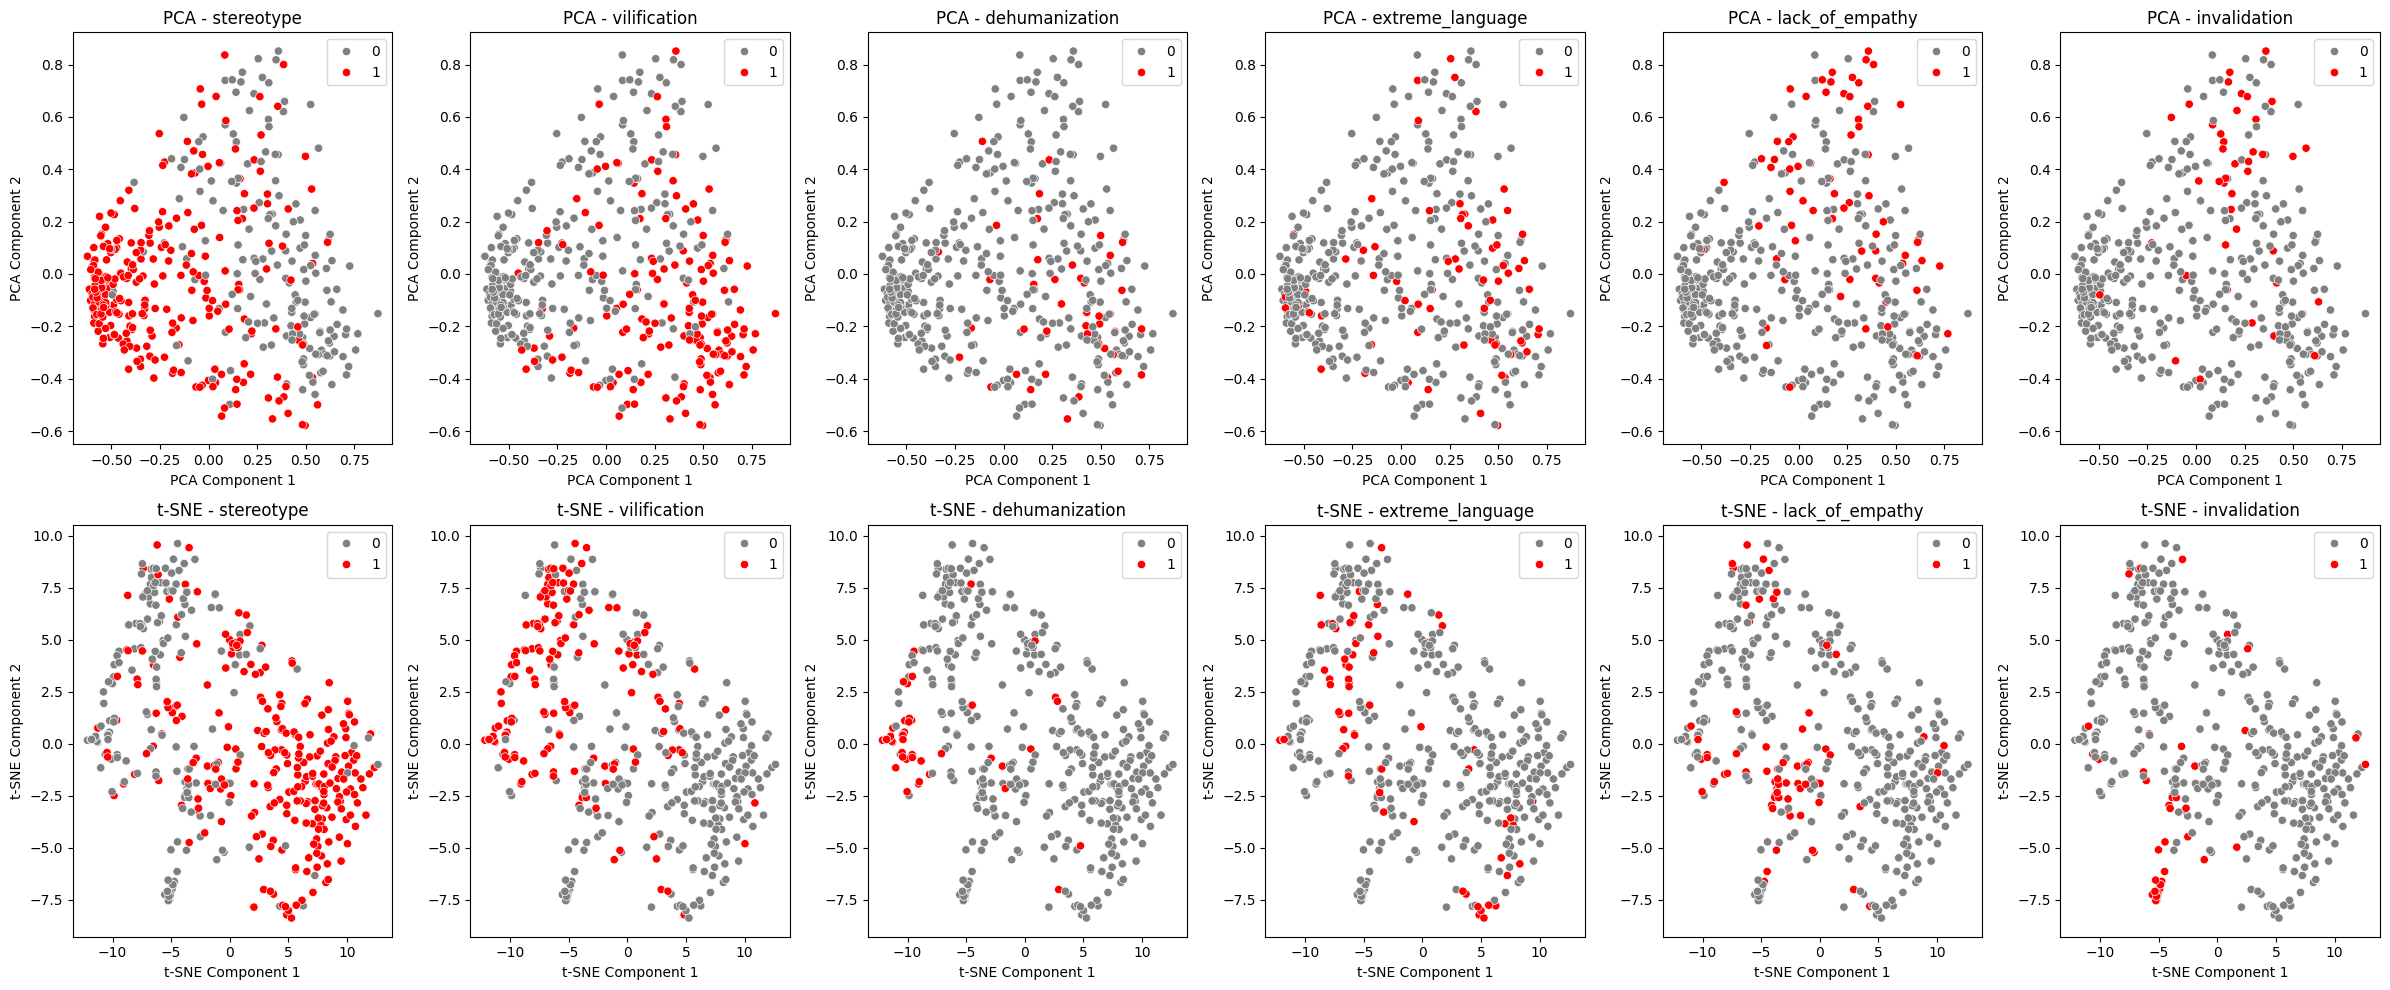

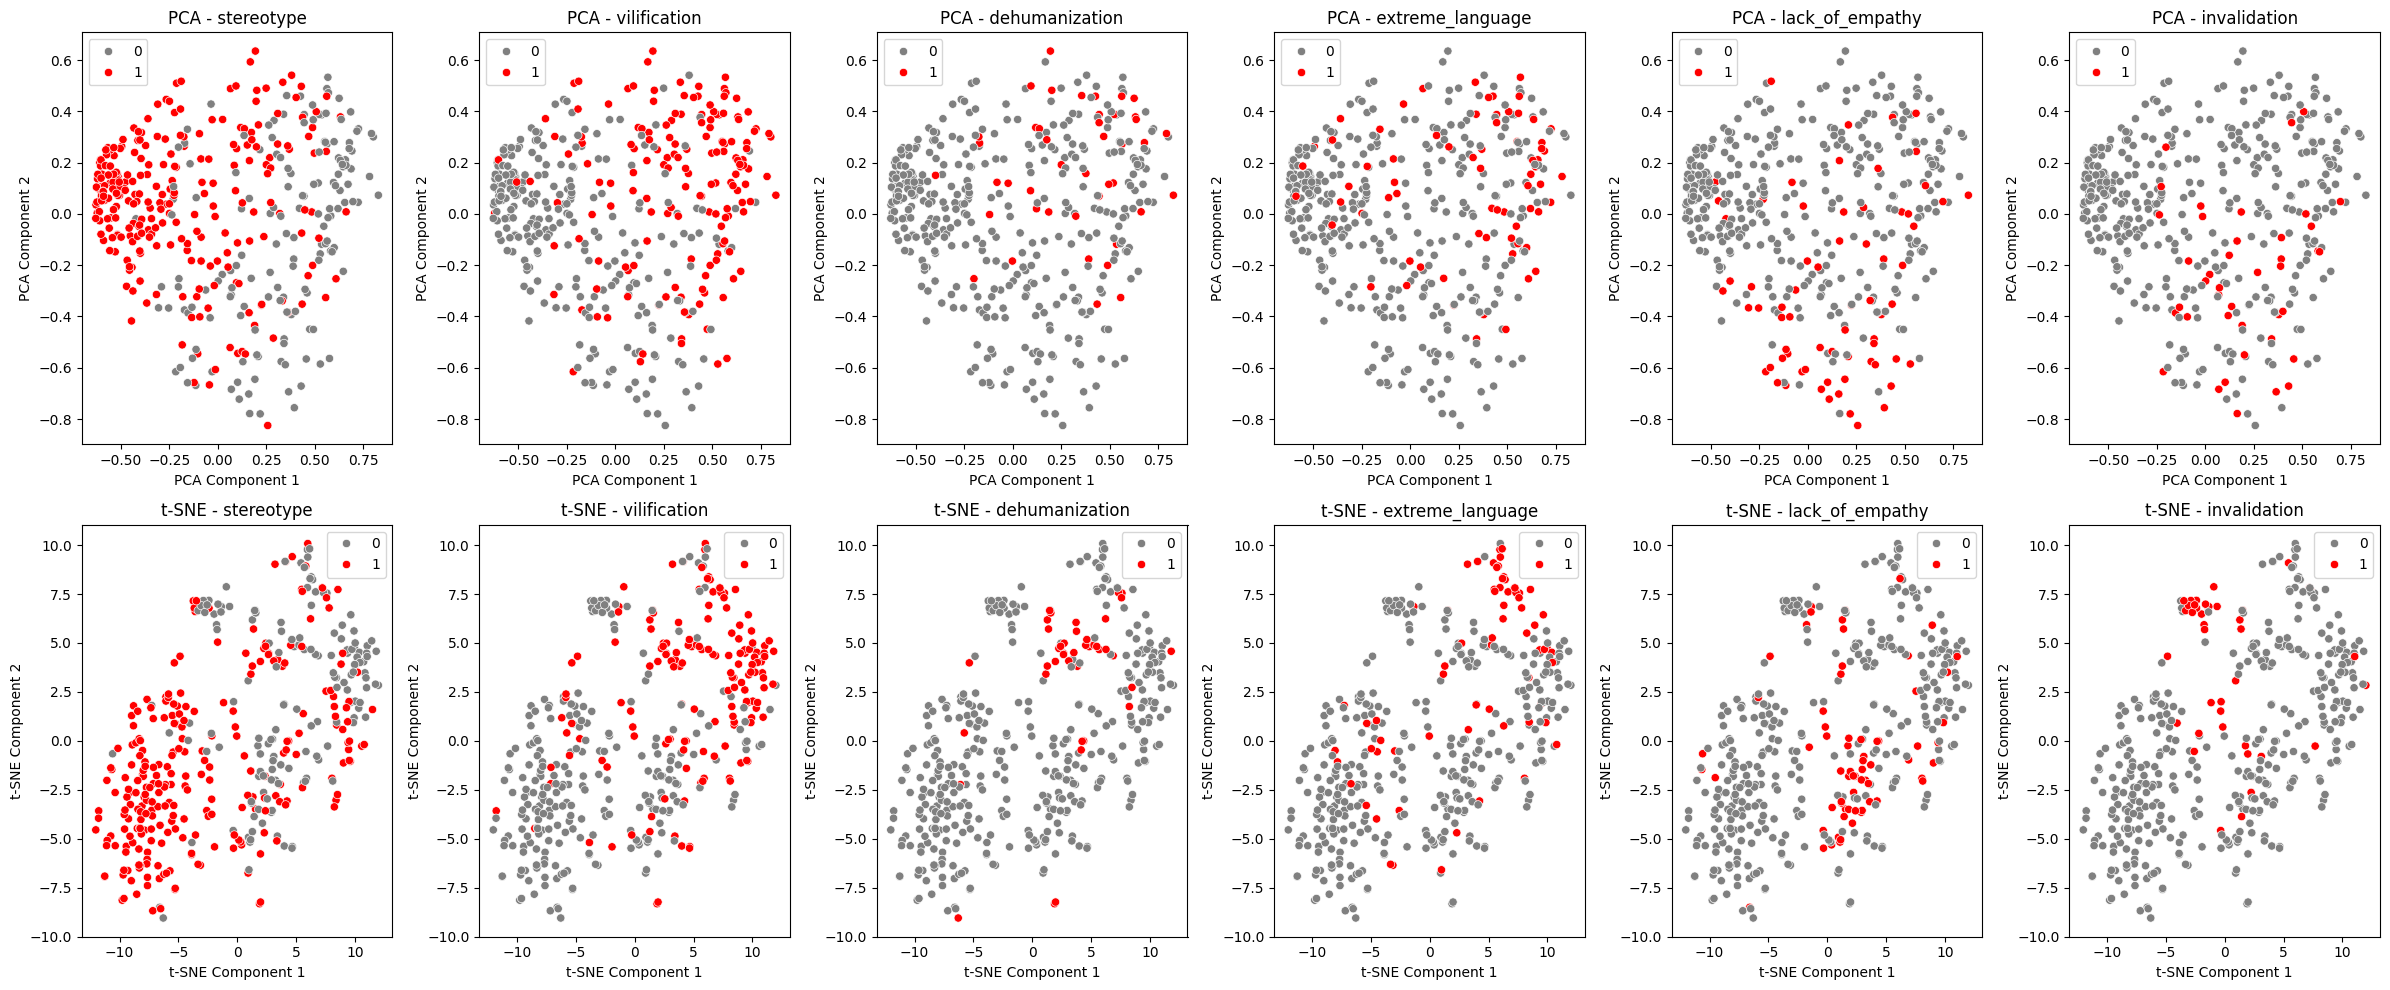

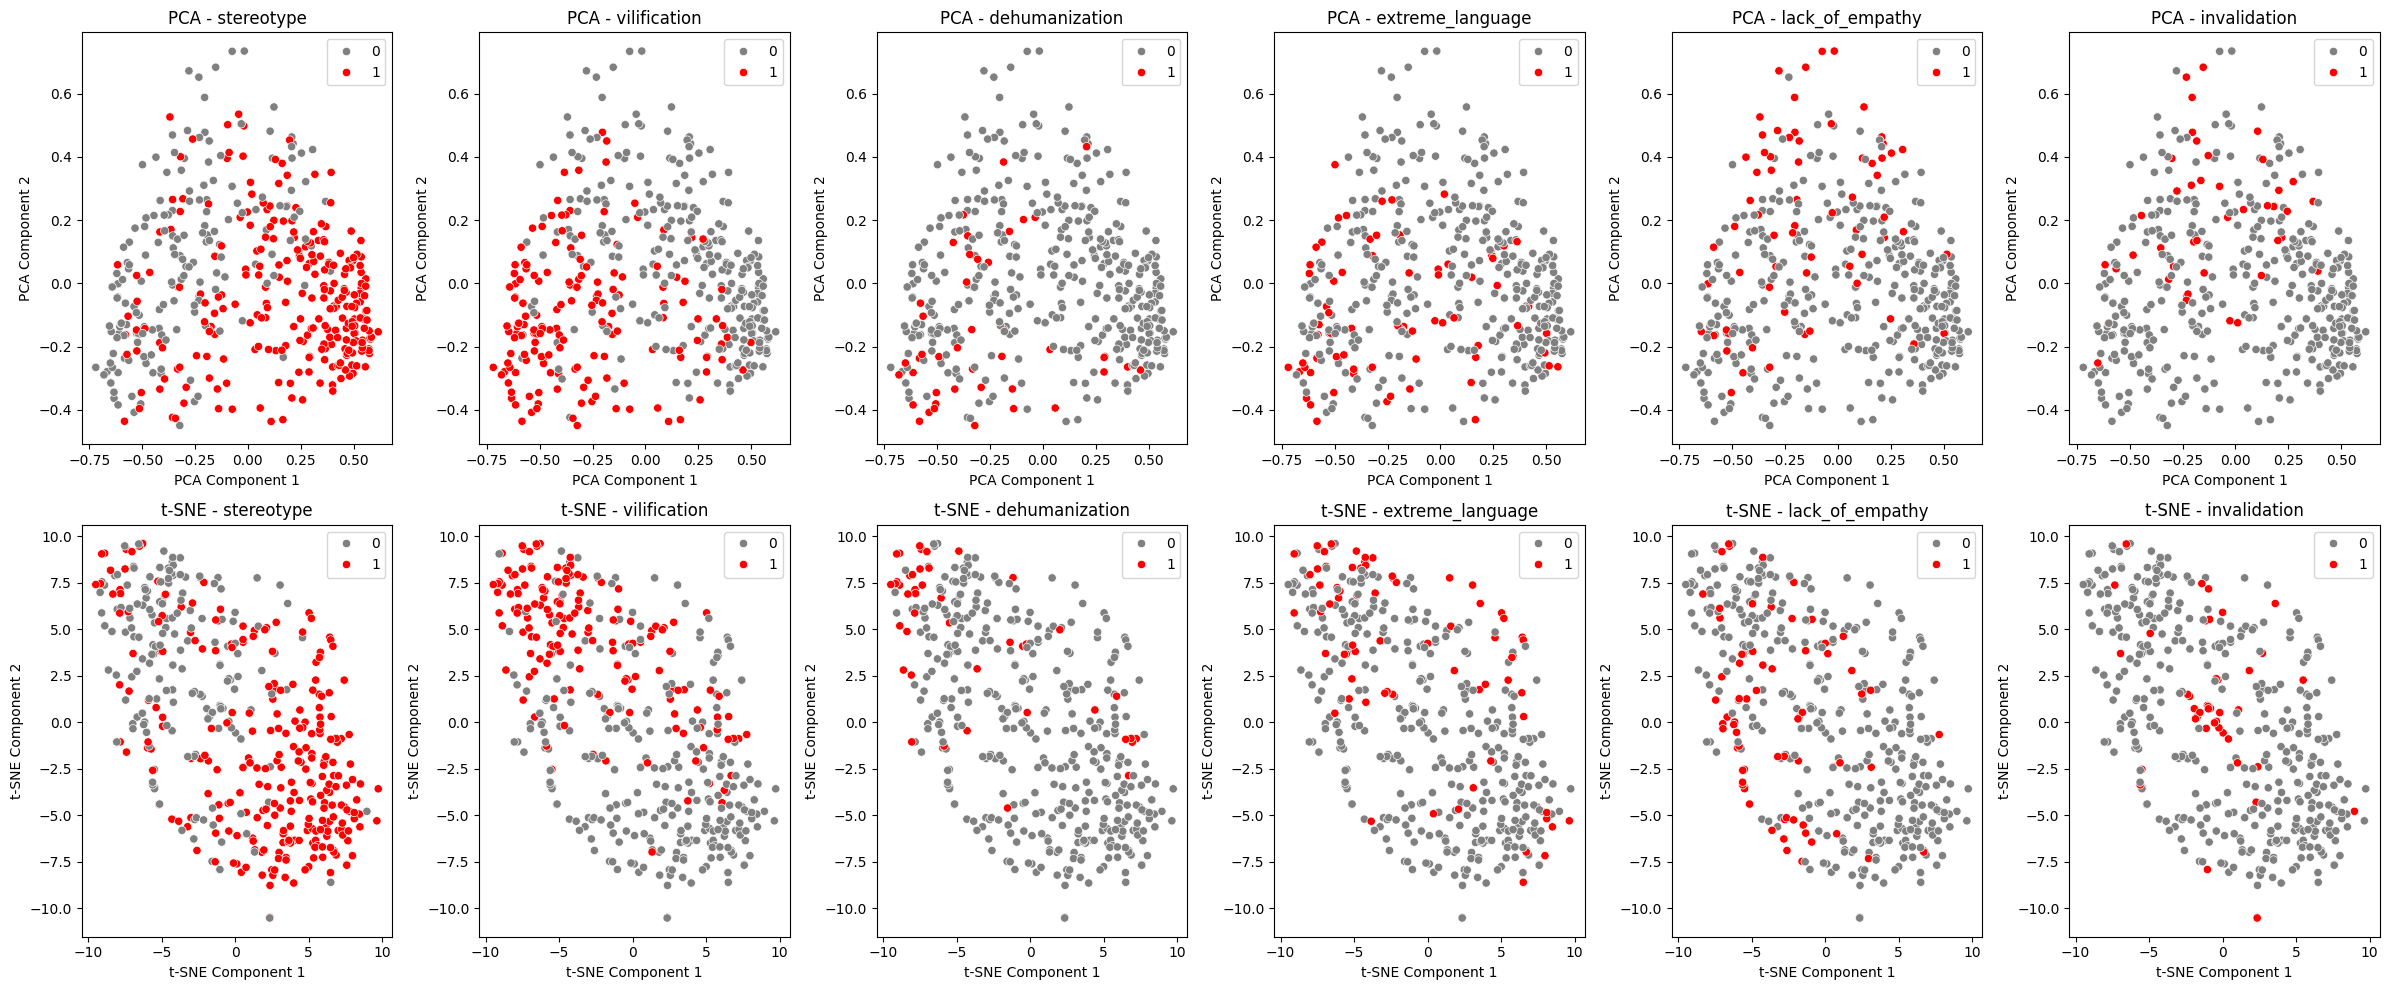

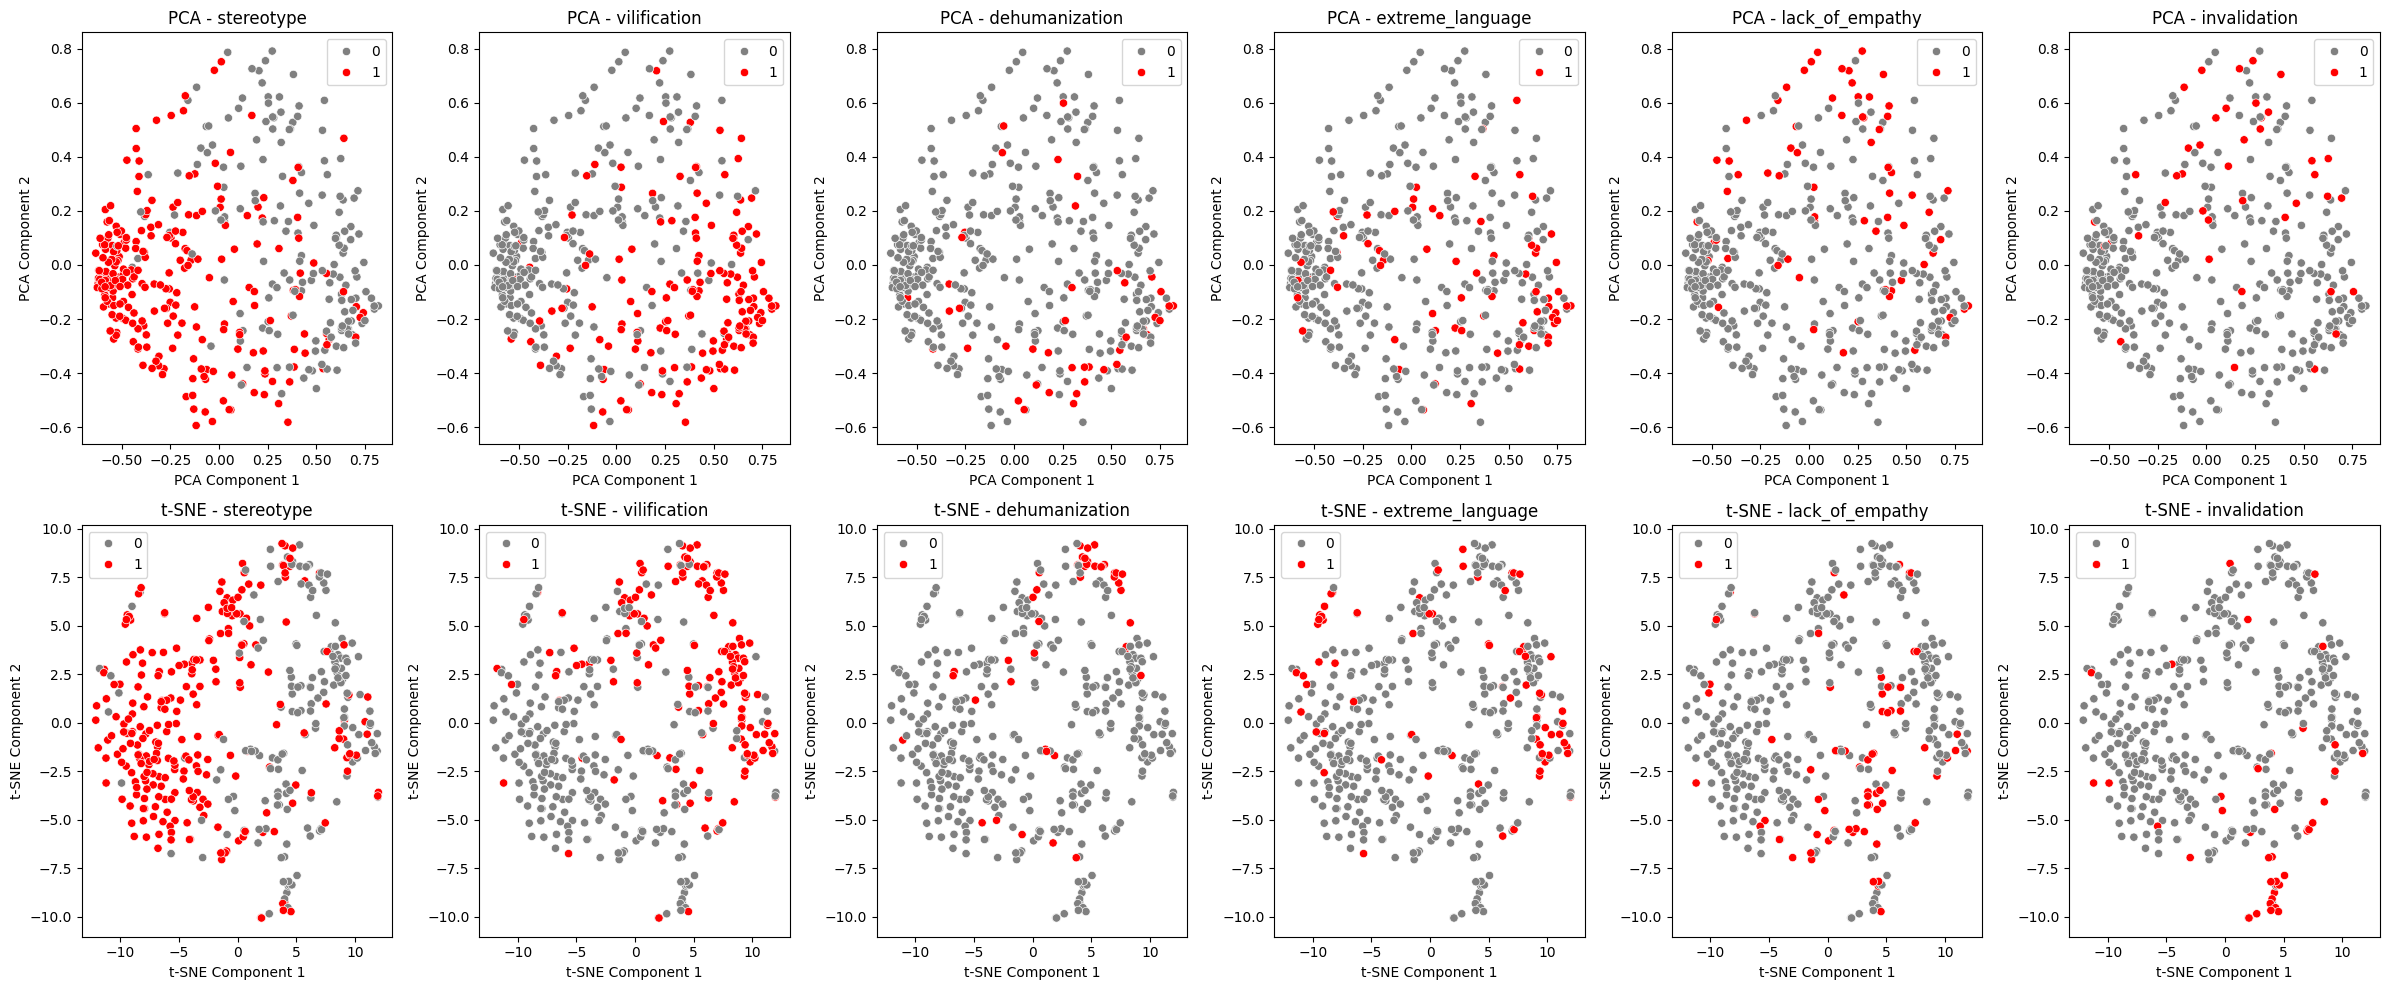

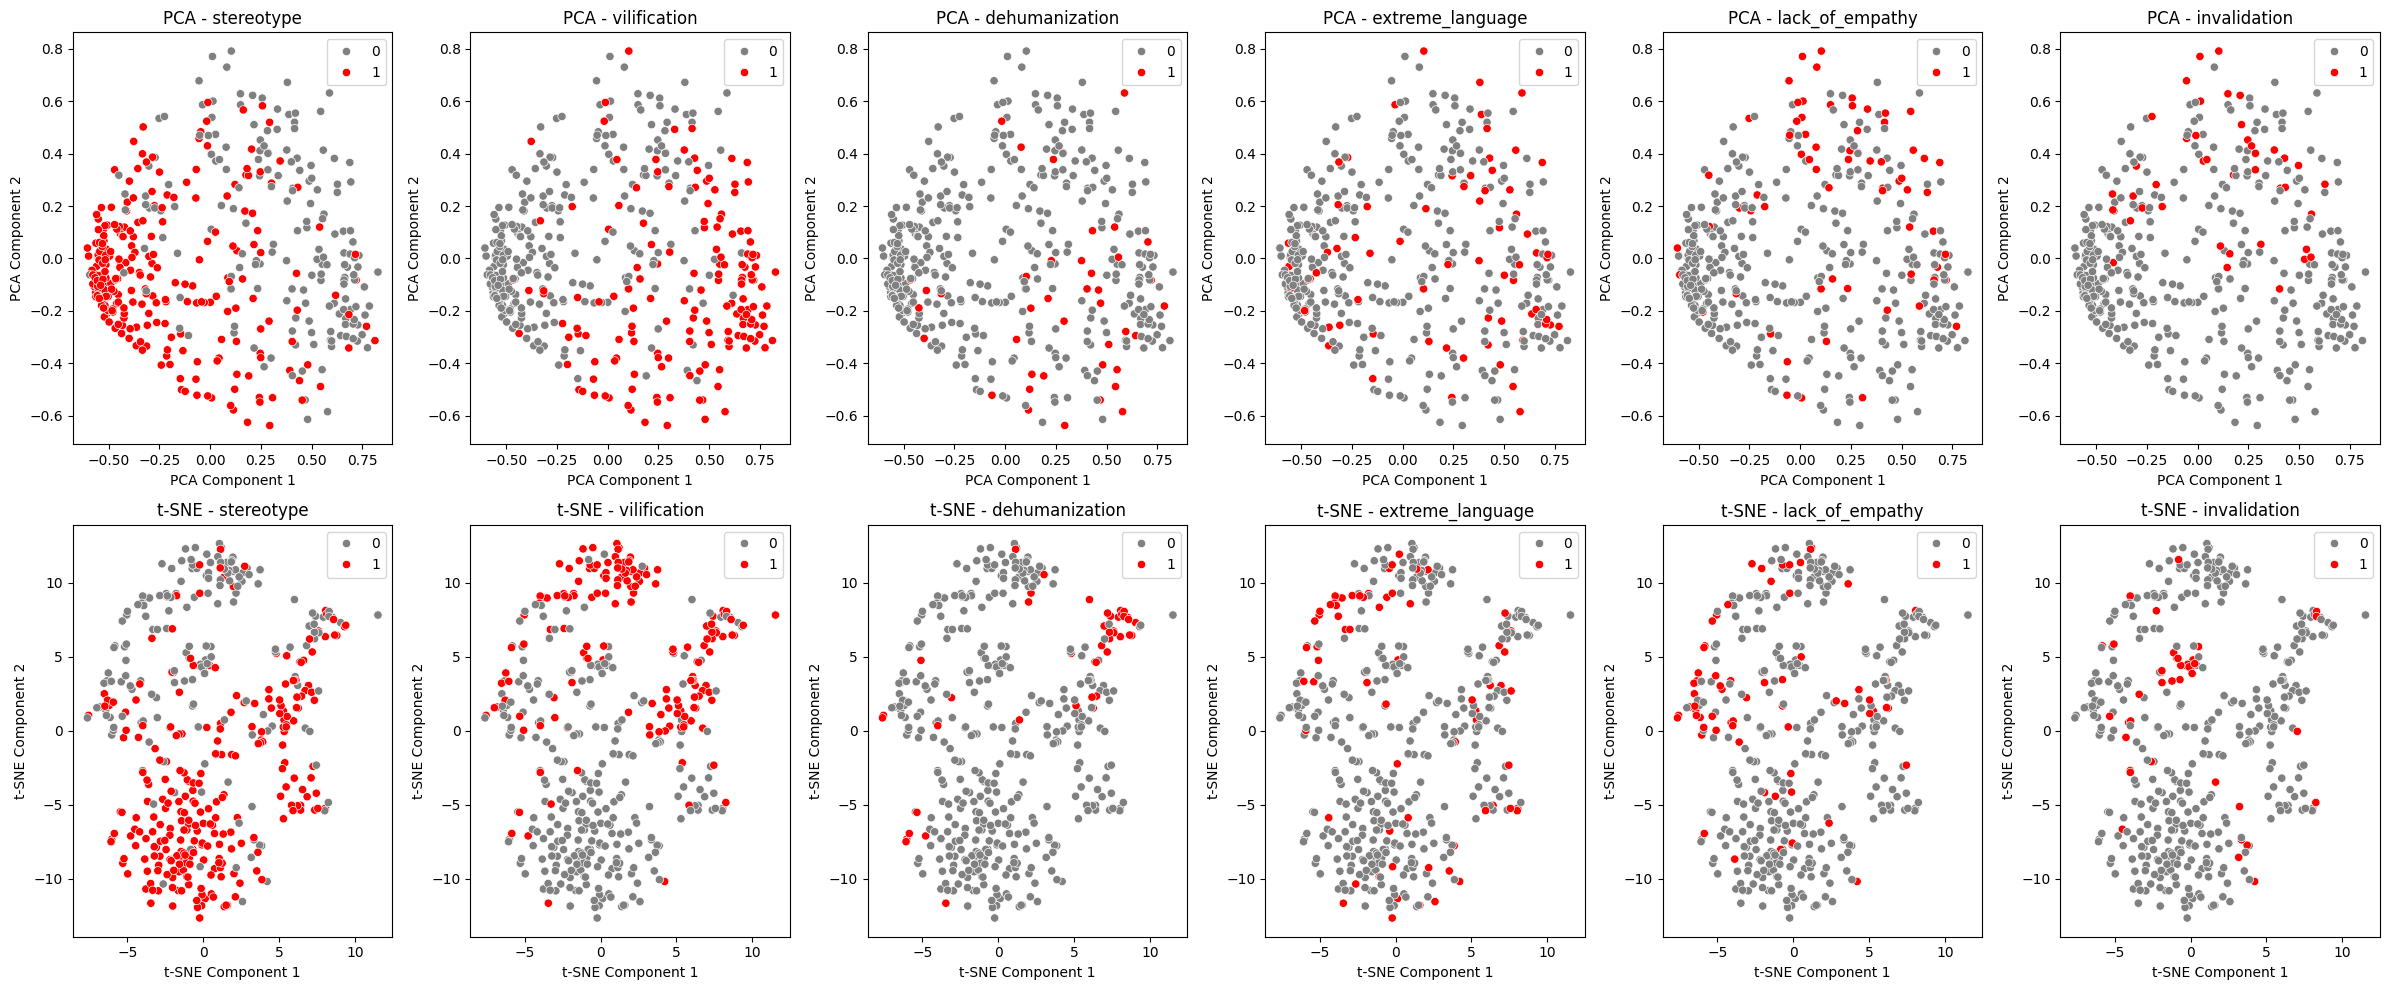

In [38]:
for fold_ids in range(K_FOLDS):
    data_index = fold_idx[fold_ids][1]

    dataset = PolarizationDataset({
        'texts': [df['text'][j] for j in data_index],
        'labels': [df[SUBTASK3_COLUMNS].iloc[j].to_list() for j in data_index]
    }, tokenizer=tokenizer)

    # Create a DataLoader for the training dataset
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE_EVAL, collate_fn=data_collator)

    embeddings, labels = get_embeddings_and_labels(model_list[fold_ids], dataloader)

    # Apply PCA for dimensionality reduction
    pca = PCA(n_components=2)
    pca_embeddings = pca.fit_transform(embeddings)

    # Apply t-SNE for dimensionality reduction (can be computationally intensive)
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=300)
    tsne_embeddings = tsne.fit_transform(embeddings)

    visualize(f'val set of fold {fold_ids}', pca_embeddings, tsne_embeddings, labels)